# 교통 표지판 이미지 분류

In [1]:
# 데이터 출처
# https://www.kaggle.com/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

In [2]:
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow
import pandas as pd
import glob
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.utils import to_categorical

In [3]:
# 1. 데이터 분석
# 1-1. 이미지 데이터 정보 파악하기 - Train
df_Train = pd.read_csv('D:/prac/traffic/Train.csv')
df_Train.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


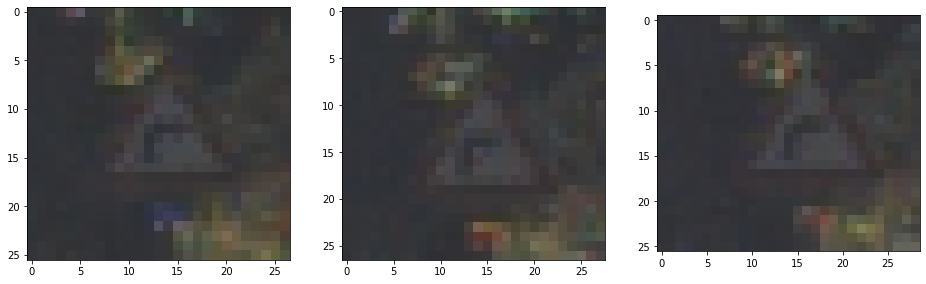

In [4]:
train_images = []
train_labels = []

plt.figure(figsize=(16,6))
for i in range(3):
    img = load_img('D:/prac/traffic/'+df_Train['Path'][i])
    plt.subplot(1, 3, i+1)
    plt.imshow(img)
    train_images.append(img)
    train_labels.append(df_Train['ClassId'][i])

C:\Users\HJ\AppData\Local\Temp/ipykernel_14840/143350890.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


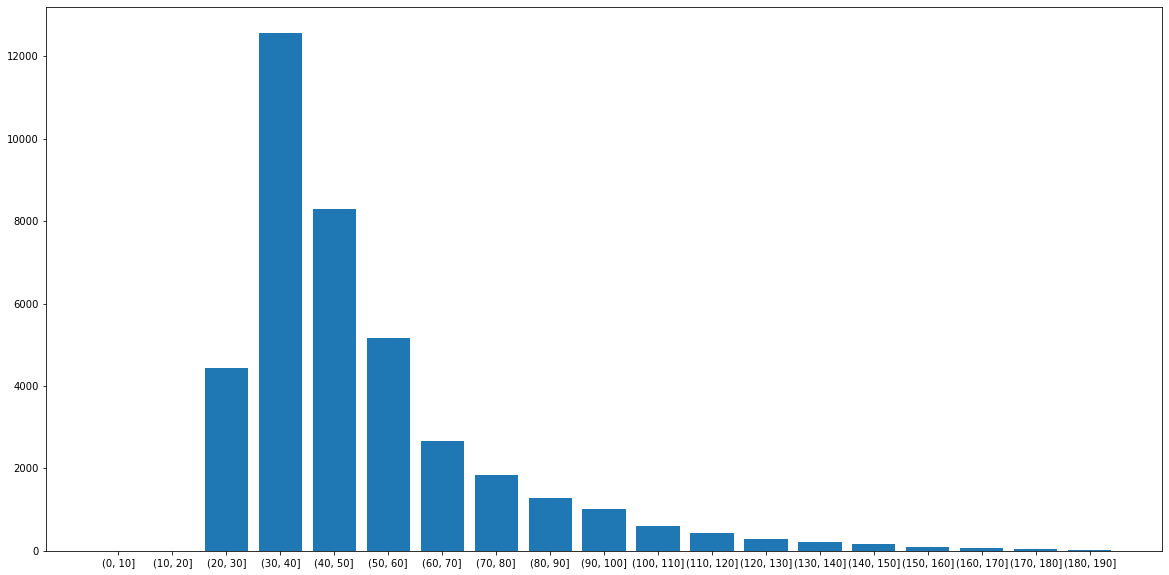

In [5]:
# 사이즈 통일을 위한 Width 범위 출력
df_cutWidth = pd.cut(df_Train['Width'], np.arange(0,200,10)).value_counts(sort=False)

fig, ax = plt.subplots(figsize=(20,10))
ax.bar(range(len(df_cutWidth)),df_cutWidth.values)
ax.set_xticks(range(len(df_cutWidth)))
ax.set_xticklabels(df_cutWidth.index)
fig.show()

In [6]:
# 1-3. 이미지 데이터 정보 파악하기 - Test
df_Test = pd.read_csv('D:/prac/traffic/Test.csv')
df_Test.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [7]:
# 2. 데이터 전 처리
# 2-1. 이미지 데이터 읽기

In [8]:
train_x =[]
for i in df_Train.Path:
    img = Image.open('D:/prac/traffic/'+i)       # reading image
    img = img.resize((30,30))     # reasizing image
    train_x.append(np.array(img)) # saving image as array to train

train_y = np.array(df_Train.ClassId)
train_x = np.array(train_x)
print(train_x.shape)
print(train_y.shape)

(39209, 30, 30, 3)
(39209,)


In [9]:
test_x =[]
for i in df_Test.Path:
    img = Image.open('D:/prac/traffic/'+i)
    img = img.resize((30,30))
    test_x.append(np.array(img))

test_y = np.array(df_Test.ClassId)
test_x = np.array(test_x)
print(test_x.shape)
print(test_y.shape)

(12630, 30, 30, 3)
(12630,)


In [10]:
## Normalization
xtrain = train_x/255
xtest = test_x/255

# One Hot encoding
ytrain = to_categorical(train_y)
ytest = to_categorical(test_y)

In [11]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(xtrain, ytrain, test_size=0.2, random_state=0)
print(x_train.shape)
print(x_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(31367, 30, 30, 3)
(7842, 30, 30, 3)
(31367, 43)
(7842, 43)


In [12]:
model = Sequential()

model.add(Conv2D(16, (5,5), activation='relu', padding='same',input_shape=(30, 30, 3)))
model.add(Conv2D(32, (5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(43, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 16)        1216      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        12832     
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 30, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 64)        2

In [14]:
# 3-2. 학습 수행
es = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1,mode='max')
lr_schedule = ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor= 0.1, min_delta=0.01, min_lr=0.0001)
mc = ModelCheckpoint(filepath="traffic_sign.h5", 
                     monitor='val_accuracy', 
                     verbose=0, 
                     save_best_only=True, mode='max')

model.compile(
    loss='categorical_crossentropy',
    optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
    )

with tensorflow.device('/gpu:0'):
    history = model.fit(x_train, 
                        y_train,
                        batch_size=16,
                        validation_data = (x_valid, y_valid),
                        epochs=50,
                        callbacks=[es,lr_schedule, mc], 
                       )

Epoch 1/50
1961/1961 [==============================] - 24s 10ms/step - loss: 2.0007 - accuracy: 0.4448 - val_loss: 0.3096 - val_accuracy: 0.8953
Epoch 2/50
1961/1961 [==============================] - 20s 10ms/step - loss: 0.3874 - accuracy: 0.8821 - val_loss: 0.1121 - val_accuracy: 0.9681
Epoch 3/50
1961/1961 [==============================] - 20s 10ms/step - loss: 0.2074 - accuracy: 0.9410 - val_loss: 0.0428 - val_accuracy: 0.9874
Epoch 4/50
1961/1961 [==============================] - 19s 10ms/step - loss: 0.1467 - accuracy: 0.9616 - val_loss: 0.0383 - val_accuracy: 0.9889
Epoch 5/50
1961/1961 [==============================] - 19s 10ms/step - loss: 0.1295 - accuracy: 0.9677 - val_loss: 0.0395 - val_accuracy: 0.9897
Epoch 6/50
1961/1961 [==============================] - 20s 10ms/step - loss: 0.1122 - accuracy: 0.9720 - val_loss: 0.0362 - val_accuracy: 0.9908
Epoch 7/50
1961/1961 [==============================] - 20s 10ms/step - loss: 0.0943 - accuracy: 0.9769 - val_loss: 0.0536 -

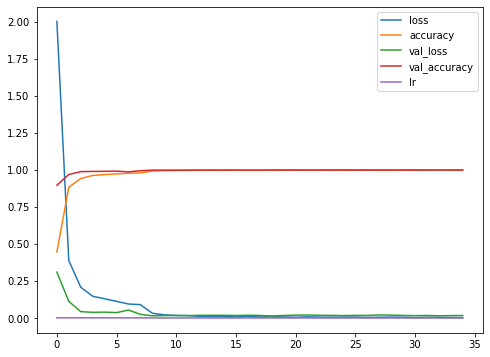

In [26]:
pd.DataFrame(history.history).plot(figsize=(8, 6))
plt.show()

In [45]:
# 3-3. 모델 성능 평가 및 예측
loss, accuracy = model.evaluate(xtest,ytest)
print(f'Loss = {loss:.5f}%')
print(f'accuracy = {accuracy*100:.5f}%')

395/395 [==============================] - 2s 4ms/step - loss: 0.1126 - accuracy: 0.9797
Loss = 0.11259%
accuracy = 97.96516%
